# Импорт данных и модулей

In [1]:
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.model_selection import GridSearchCV, train_test_split, learning_curve, cross_validate
from sklearn.pipeline import Pipeline
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans

from scipy import stats

import warnings
warnings.filterwarnings("ignore")
np.random.seed(100)

In [2]:
import sklearn

In [3]:
sklearn.__version__

'1.0.2'

In [ ]:
df_main = pd.read_csv('data/winequality-red.csv')
df_main.columns = list(map(lambda x: x.replace(' ',  '_'), df_main.columns))
df_main

In [ ]:
def return_X_y(df):
    X = df.drop(labels=['quality'], axis=1)
    y = df['quality']
    return X, y

In [ ]:
df_features = df_main.copy()
df_train, df_test = train_test_split(df_main, train_size=0.8)
df_X = df_main.drop('quality', axis=1)
df_y = df_main['quality']

# Формирование целей

Цель: на данном датасете я хочу выяснить какие показатели сильнее всего влияют на качество вина, а также написать регрессор, который по хим. составу будет определять качество

# Разведывательный анализ данных

## Поиск nan и определение типов столбцов

In [5]:
df_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed_acidity         1599 non-null   float64
 1   volatile_acidity      1599 non-null   float64
 2   citric_acid           1599 non-null   float64
 3   residual_sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free_sulfur_dioxide   1599 non-null   float64
 6   total_sulfur_dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [6]:
df_main.describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


Вывод: нет ни одного nan, все столбцы являются непрерывными(кроме quality)

## Target под прицелом

In [7]:
df_main['quality'].describe()

count    1599.000000
mean        5.636023
std         0.807569
min         3.000000
25%         5.000000
50%         6.000000
75%         6.000000
max         8.000000
Name: quality, dtype: float64

<AxesSubplot:xlabel='quality', ylabel='count'>

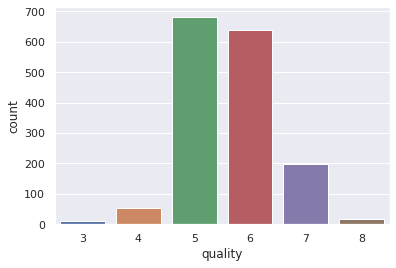

In [8]:
sns.countplot(x=df_main['quality'])

In [9]:
rows = df_main.shape[0]
percents = df_main.groupby('quality')['fixed_acidity'].agg('count') / rows * 100
percents.name = 'percents'
percents

quality
3     0.625391
4     3.314572
5    42.589118
6    39.899937
7    12.445278
8     1.125704
Name: percents, dtype: float64

Вывод:
* Видим, что классы не сбалансированы, а также хоть и шкала 10 бальная, по факту используется только 6 оценок.
* Оценки 3, 8, 4 крайне редки

## Первичное исследование на взаимосвязи

### mi score

In [10]:
from sklearn.feature_selection import mutual_info_classif

def make_mi_scores(X, y):
    mi_scores = mutual_info_classif(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

<AxesSubplot:>

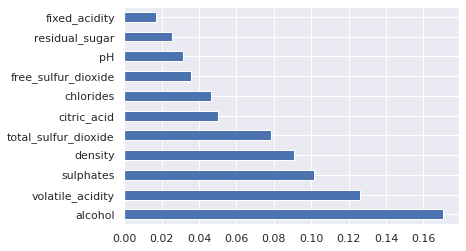

In [11]:
mi_score = make_mi_scores(df_X, df_y)
mi_score.plot(kind='barh')

### correlation

<AxesSubplot:>

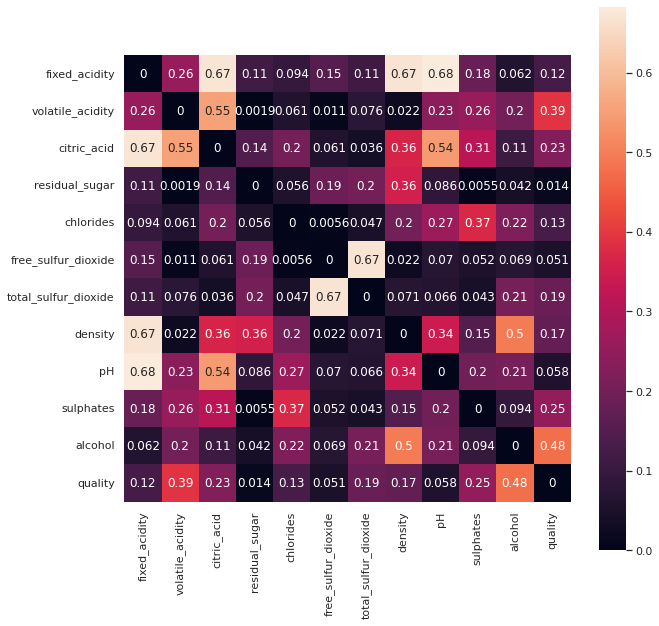

In [12]:
plt.figure(figsize=(10, 10))
corr_matr = df_main.corr()
corr_matr = corr_matr.abs()
corr_matr[corr_matr == 1] = 0
# corr_matr.sort_values('quality', ascending=False,inplace=True)
sns.heatmap(corr_matr, square=True, annot=True)

<AxesSubplot:>

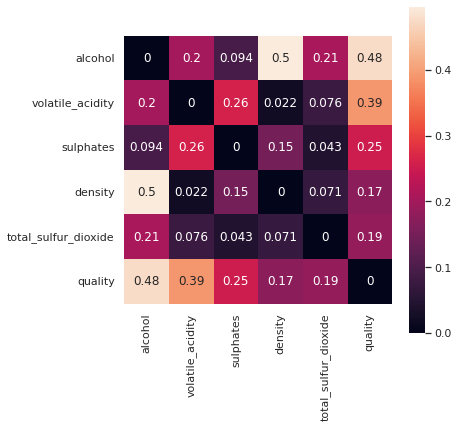

In [13]:
plt.figure(figsize=(6, 6))
corr_matr = df_main[mi_score[:5].index.to_list()+['quality']].corr()
corr_matr = corr_matr.abs()
corr_matr[corr_matr == 1] = 0
# corr_matr.sort_values('quality', ascending=False,inplace=True)
sns.heatmap(corr_matr, square=True, annot=True)


Выводы:
* Fixed_acidity сильно коррелирует с citric_acid, density, ph. Возможно Fixed - это подмножество citric или наоборот
* citric_acid с ph и violate_acidity
* density с alcohol
* Total_sulfur_dioxide с free_sulfur_dioxide. Неудевительно.


### pairplot. 5 самых важных фич

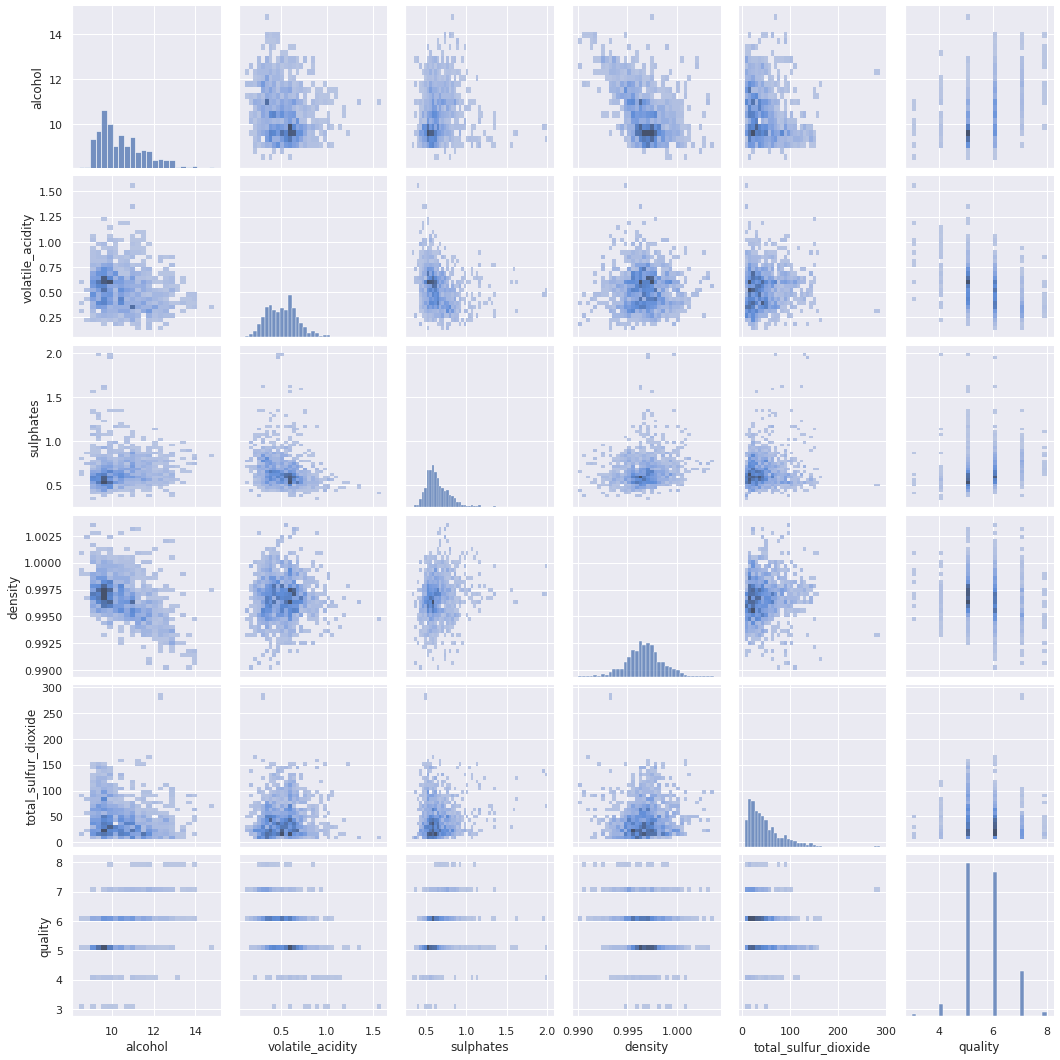

In [14]:
most_important_features = mi_score[:5].index.to_list()
sns.pairplot(df_main[most_important_features+['quality']], kind='hist')

Выводы по pairplot:
* Все кроме total_sulfur_dioxide - распределение похожее на нормальное
* total_sulfur_dioxide - чем-то напоминает экспоненциальное распределение
* total_sulfur_dioxide - сильный выброс, имеющий значение 300
* suplates - выбросы к значению 2

## Формулировка целей после разведывательного анализа

1. Исследовать маргинальные распределения {alcohol, volatile_acidity, sulphates, density} и если надо применить boxcox transformation
2. Изучение выбросов {total_sulfur_dioxide, suplates}
3. Узнать какие плюсы нам дает экспоненциальное распределение total_sulfur_dioxide и проверить является ли оно экспоненциальным
4. Взаимосвязи кислот между собой и ph, возможно сделать новый фичи на основании этой информации
5. fixed_acidity и {density, ph, citric_acid}
6. Взаимосвязь Total_sulfur_dioxide и free_sulfur_dioxide
7. density с alcohol. Почему density сильно коррелирует с alcohol, а alcohol с quality, но quality с  density не коррелируют
8. density с fixed_acidity. Что может скрываться за такой сильной корреляцией?


# Углубленный анализ

## density и alcohol

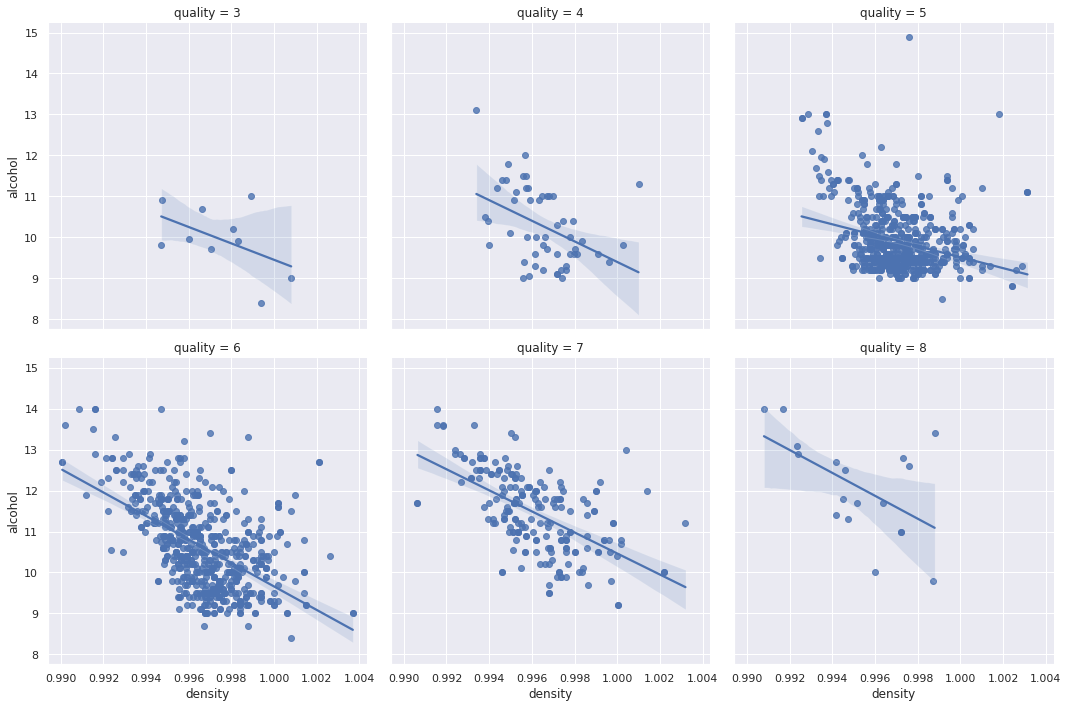

In [15]:
sns.lmplot(data=df_main, x='density', y='alcohol', col='quality', col_wrap=3)

Можно заметить различные наклоны прямых, поэтому попробуем посмотреть на соотношение

<AxesSubplot:xlabel='quality', ylabel='alcohol_density_ratio'>

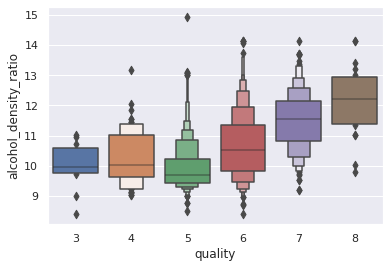

In [16]:
df_features['alcohol_density_ratio'] = df_features['alcohol'] / df_features['density']
sns.boxenplot(data=df_features, x='quality', y='alcohol_density_ratio')

Получилась неплохая фича

## Кислоты  и Ph

In [17]:
acid_cols = [col for col in df_main.columns if 'acid' in col]
acid_cols.append('pH')
acid_cols

['fixed_acidity', 'volatile_acidity', 'citric_acid', 'pH']

<AxesSubplot:>

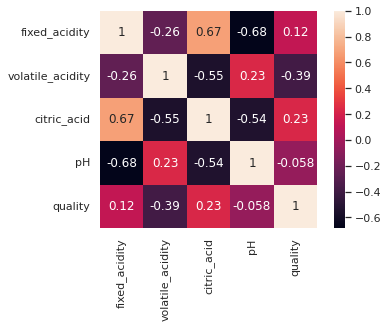

In [18]:
sns.heatmap(df_main[acid_cols+['quality']].corr(), square=True, annot=True)

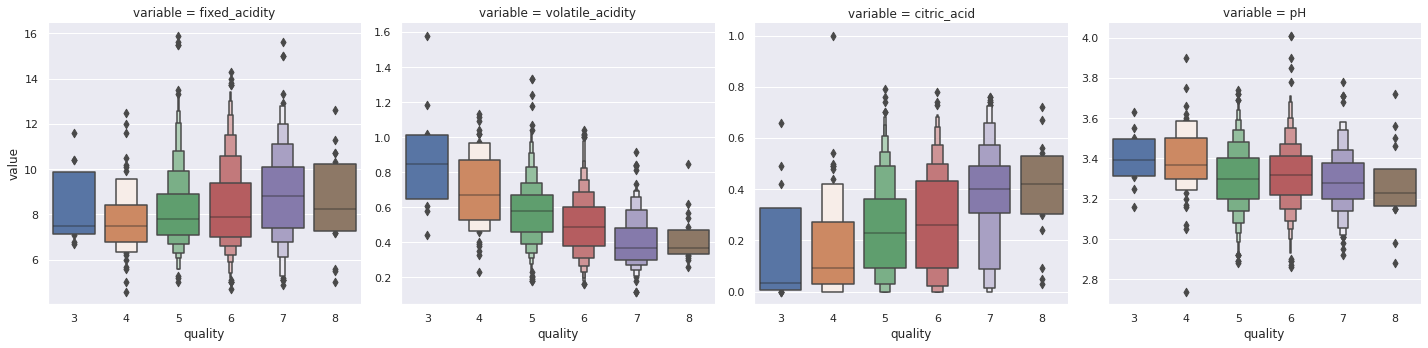

In [19]:
tmp = df_main.melt(id_vars=['quality'], value_vars=acid_cols)
sns.catplot(data=tmp, x='quality', y='value', col='variable', kind='boxen', sharey=False)

### fixed_acidity и volatile_acidity

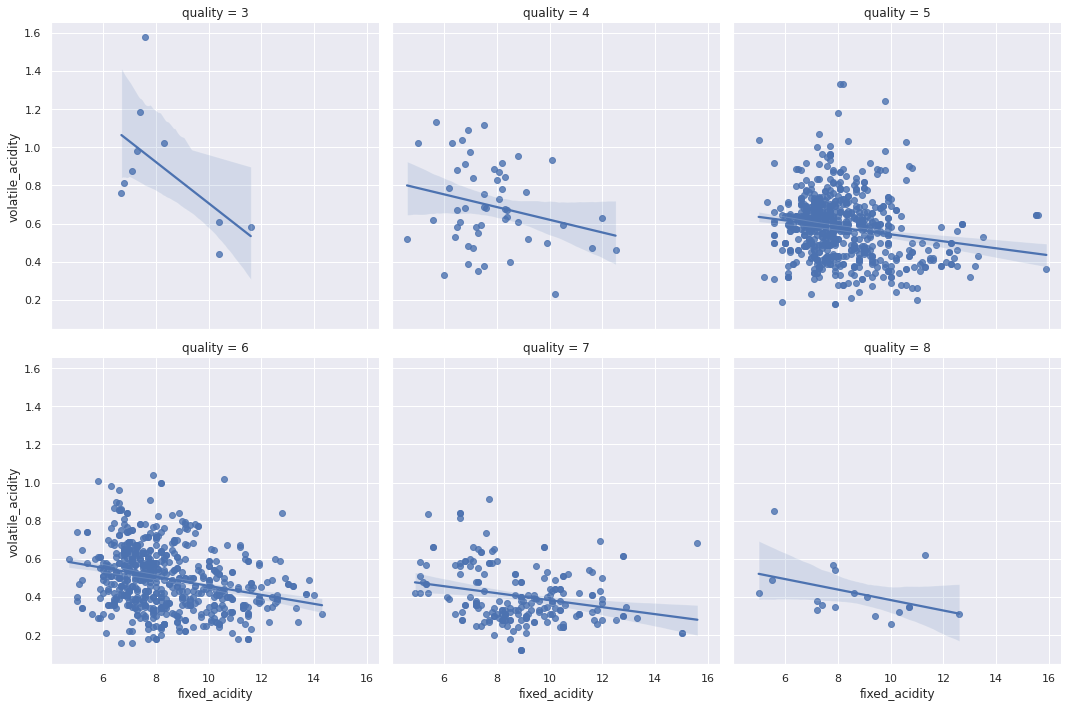

In [20]:
sns.lmplot(data=df_main, x='fixed_acidity', y='volatile_acidity', col='quality', col_wrap=3)

Особых различий в прямых нет, так что отношение не будет хорошей фичей

In [21]:
def permutation_func(X, y, n):
    """
    shuffle data
    add labels
    look at regression coef
    """
    coefs = np.zeros([n])
    X = X.copy()
    y = y.copy()
    for i in range(n):
        np.random.shuffle(y)
        coef = linear_model.LinearRegression().fit(X, y).coef_
        coefs[i] = coef
    return coefs

def plot_permutation(X, y, n):
    coefs = permutation_func(X, y, n)

    model = linear_model.LinearRegression()
    model.fit(X, y)
    real_coef = model.coef_

    sns.displot(coefs)
    plt.axvline(real_coef, c='orange')

In [ ]:
scaler = StandardScaler()
fixed_scaled=  np.ravel(scaler.fit_transform(df_main[['fixed_acidity']]))
volatile_scaled = np.ravel(scaler. fit_transform(df_main[['volatile_acidity']]))
sum_acid_scaled = fixed_scaled + volatile_scaled
sns.boxenplot(x=df_main['quality'], y=sum_acid_scaled)

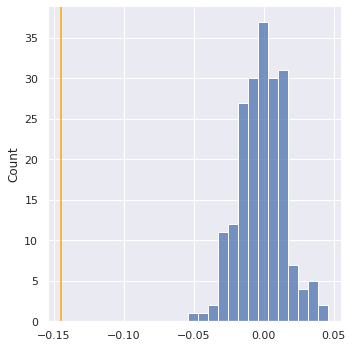

In [24]:
plot_permutation(sum_acid_scaled[:, np.newaxis], df_main['quality'], 200)

In [26]:
df_features['sum_acid_scaled'] = sum_acid_scaled

In [27]:
def get_model_error(df, feature_list, model=None):
    if model is None:
        model = linear_model.LinearRegression()
    X = df[feature_list]
    y = df['quality']
    cv = cross_validate(model, X, y, scoring='neg_median_absolute_error')
    cv = pd.DataFrame(cv)
    return -cv['test_score'].mean()


In [28]:
get_model_error(df_features, ['volatile_acidity', 'fixed_acidity'])

0.5179337571434794

In [29]:
get_model_error(df_features, ['volatile_acidity', 'sum_acid_scaled'])

0.5179337571434796

In [30]:
df_features.drop('sum_acid_scaled', axis=1, inplace=True)

Вывод: фичу sum_acid_scaled не следует использовать, потому что оно не несет в себе пользы, даже несмотря на то, что произошла нормализация

### TODO
1. Проверить действительно ли сумма нормированных fixed_acidity и volatile_acidity хороша, как фича
2. Проверить отношение fixed_acidity к volatile_acidity
3. citric и fixed(citric является частью  fixed), поискать взаимосвязи с quality
4. Попробовать сложить все кислоты, а потом поделить кислоты на эту сумма. Что получится? (Сделать линейный предсказатель)
5. pH и высокая кислотность, посмотеть на взаимосвязь в quality
6. Попробовать выделить кластеры при помощи kmeans, используя всю информацию о кислотности

### citric acid и fixed acid

Я решил рассмотреть данную пару фич, потому что cirtic_acid является составляющей частью fixed_acid

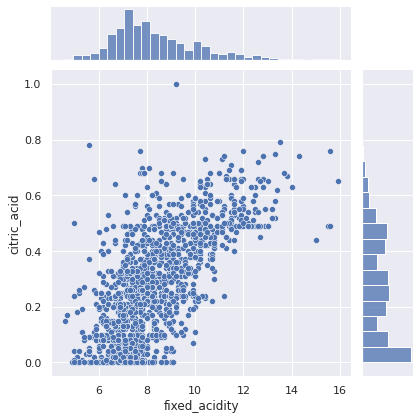

In [31]:
sns.jointplot(x=df_main['fixed_acidity'], y=df_main['citric_acid'])

Можем заметить, что есть довольно большое количество нулей, рассмотрим их более подробно

In [32]:
mask = df_main['citric_acid'] == 0
mask.sum()

132

In [33]:
mean_mask = df_main.loc[mask, 'quality'].mean()
mean_not_mask = df_main.loc[~mask, 'quality'].mean()
mean_dif = mean_mask - mean_not_mask
print(f'Разница средних: {mean_dif}')

Разница средних: -0.24735080870050208


In [34]:
labels = mask.copy()
mean_dif_list = []
for i in range(1000):
    np.random.shuffle(labels)
    a = df_main.loc[labels, 'quality']
    b = df_main.loc[~labels, 'quality']
    mean_dif_list.append(a.mean() - b.mean())


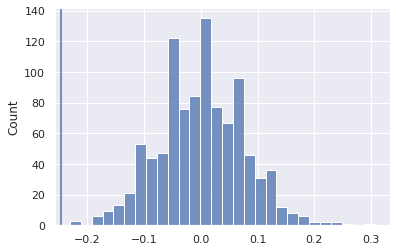

In [35]:
sns.histplot(mean_dif_list)
plt.axvline(mean_dif)

Вывод, разница между вина без цитрусовой кислоты и с значительна, так что можем добавить отсутствие цитрусовок кислоты как фичу

## total_sulfur_dioxide и free_sulfur_dioxide

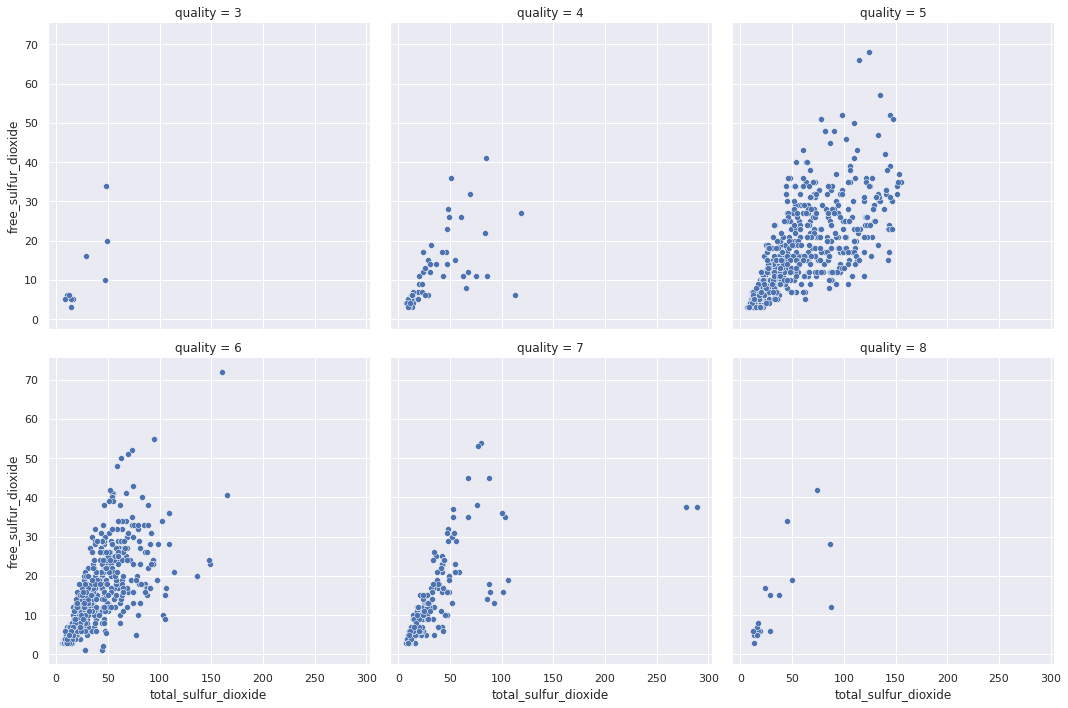

In [36]:
sns.relplot(data=df_main, x='total_sulfur_dioxide', y='free_sulfur_dioxide', col='quality', col_wrap=3)

Не видно особых различий в распределении, поэтому попробуем создать новую фичу

In [37]:
df_features['sulfur_ratio'] = df_main['total_sulfur_dioxide'] / df_main['free_sulfur_dioxide']

<AxesSubplot:xlabel='quality', ylabel='sulfur_ratio'>

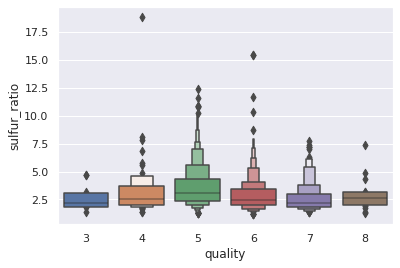

In [38]:
mask = df_features['sulfur_ratio'] < 20
sns.boxenplot(data=df_features[mask], x='quality', y='sulfur_ratio')

Тоже не видно собых различий в распределении

## Маргинальные распределения

In [39]:
def plot_norm(series: pd.Series, ax=None):
    if ax is None:
        ax = plt.gca()
    mu, std = stats.norm.fit(series)
    xmin = series.min() - 1 * std
    xmax = series.max() + 1 * std
    x = np.linspace(xmin, xmax, 100)
    y = stats.norm.pdf(x, mu, std)
    ax.plot(x, y, 'k', linewidth=2)
    plt.xlim([xmin, xmax])


def plot_compare_with_normal(series: pd.Series):
    sns.displot(series, stat="density", kde=True)
    plot_norm(series)

### alcohol

hint: что нормальное распределение значит для нас?

skew: 0.86


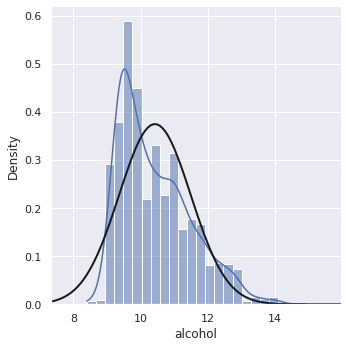

In [40]:
print('skew:', round(df_main['alcohol'].skew(), 2))
plot_compare_with_normal(df_main['alcohol'])

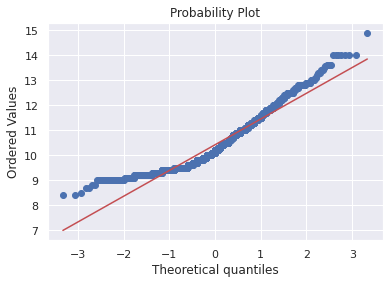

In [41]:
stats.probplot(df_main['alcohol'], dist='norm',plot=plt);

Очевидно, что распределение не нормальное, а скорее похоже на экспоненциальное

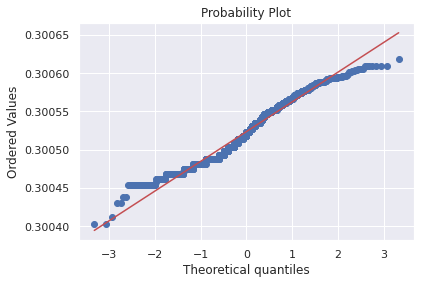

In [42]:
normalized = stats.boxcox(df_main['alcohol'])[0]
stats.probplot(normalized, plot=plt);

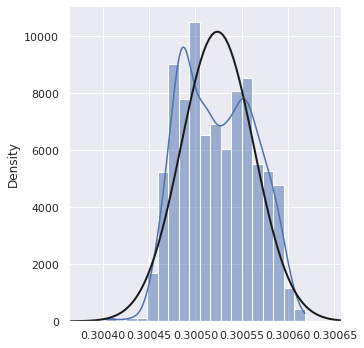

In [43]:
plot_compare_with_normal(normalized)

## Анализ выбросов

### total_sulfur_dioxide

<AxesSubplot:xlabel='total_sulfur_dioxide', ylabel='Count'>

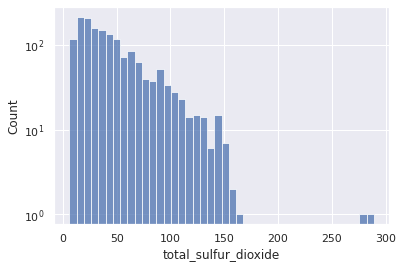

In [44]:
ax = plt.gca()
ax.set(yscale='log')
sns.histplot(x=df_main['total_sulfur_dioxide'])

In [45]:
mask = df_main['total_sulfur_dioxide'] > 250
outliers = df_main.loc[mask]

In [46]:
outliers

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
1079,7.9,0.3,0.68,8.3,0.05,37.5,278.0,0.99316,3.01,0.51,12.3,7
1081,7.9,0.3,0.68,8.3,0.05,37.5,289.0,0.99316,3.01,0.51,12.3,7


Мы потом вернемся к этим данным

##  suplates

# Применение моделей к необработанным данным


In [47]:
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, train_size=0.8)

## Ridge

In [48]:
def get_rmse(y_predicted, y_test):
    return round(np.sqrt(mean_squared_error(y_test, y_predicted)), 2)

def plot_predictions(y_predicted, y_test, ax=None):
    if ax is None:
        ax = plt.gca()
    ax.scatter(y_predicted, y_test, alpha=0.4)
    min_max = [0, 10]
    ax.plot(min_max, min_max)
    ax.set_xlabel('y_predicted')
    ax.set_ylabel('y_test')


def plot_residuals(y_predicted, y_test, ax=None):
    if ax is None:
        ax = plt.gca()
    residuals = y_predicted - y_test
    ax.scatter(y_predicted, residuals, alpha=0.4)
    ax.plot([0, y_test.max()], [0, 0])
    ax.set_xlabel('WineQuality')
    ax.set_ylabel('Residual')

def plot_residuals_and_predictions(y_predicted, y_test, figsize=(14, 5)):
    _, axes = plt.subplots(1, 2, figsize=figsize)
    print('rmse:', get_rmse(y_predicted, y_test))
    plot_predictions(y_predicted, y_test, ax=axes[0])
    plot_residuals(y_predicted, y_test, ax=axes[1])

def get_coefs_of_regression(regression, df):
    coeffs = dict(zip(df.columns.values, np.ravel(regression.coef_)))
    coeffs['intercept'] = regression.intercept_
    coeffs = pd.Series(coeffs).sort_values(ascending=False)
    return coeffs

def get_grid_trainig_result(cv_results):
    result = pd.DataFrame(cv_results)
    result.sort_values(by='rank_test_score', inplace=True)
    result['mean_test_score'] = np.sqrt(-result['mean_test_score'])
    return result

In [49]:
def create_pipe(ridge_parameters):
    return Pipeline([('scaler', MinMaxScaler()),
                     ('estimator', linear_model.RidgeCV(**ridge_parameters))])

ridge_parameters = {
    'alphas': [0.01,0.05, 0.1, 1, 4, 8, 16, 32, 64, 128],
    'cv': 10,
    'scoring': 'neg_root_mean_squared_error'
}
# обучаем модель, подбирая лучший параметр регуляризации
ridge_pipe = create_pipe(ridge_parameters)
ridge_pipe.fit(X_train, y_train)
# ищем вблики alpha, который оказался лучшем параметром
best_alpha = ridge_pipe['estimator'].alpha_
near_alphas = np.arange(0.6, 1.4, 0.05) * best_alpha
ridge_parameters['alphas'] = near_alphas
ridge_pipe = create_pipe(ridge_parameters)
ridge_pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('estimator',
                 RidgeCV(alphas=array([0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  , 1.05, 1.1 ,
       1.15, 1.2 , 1.25, 1.3 , 1.35]),
                         cv=10, scoring='neg_root_mean_squared_error'))])

Посмотрим как себя ведет модель на тестовых данных

rmse: 0.66


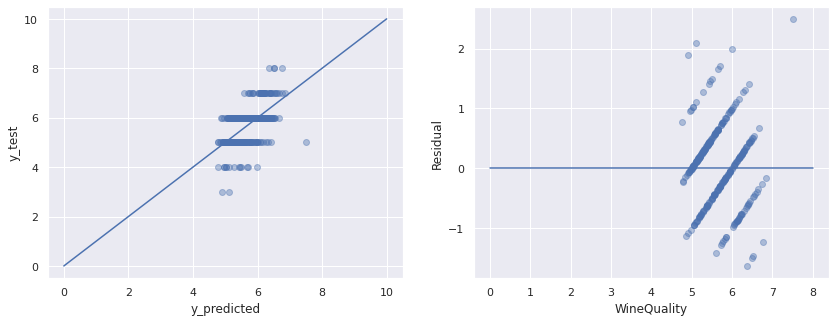

In [50]:
y_pred_test = ridge_pipe.predict(X_test)
plot_residuals_and_predictions(y_pred_test, y_test)

На тренировочных

rmse: 0.64


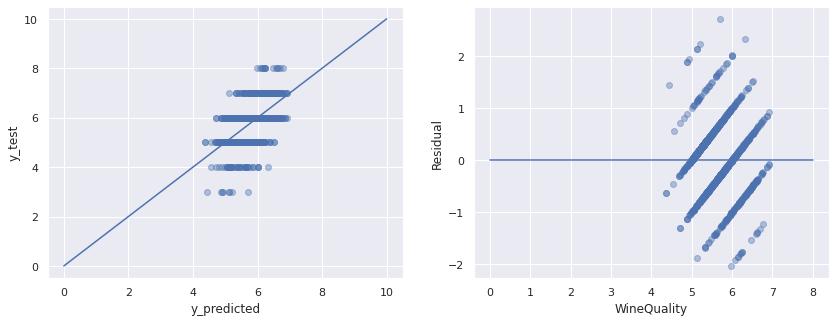

In [51]:
y_pred_train = ridge_pipe.predict(X_train)
plot_residuals_and_predictions(y_pred_train, y_train)

In [55]:
bins = (2, 6.5, 8)
labels = [0, 1]
quality_changed = pd.cut(x=df_main['quality'], bins=bins, labels=labels)

In [53]:
df_main['quality']

0       0
1       0
2       0
3       0
4       0
       ..
1594    0
1595    0
1596    0
1597    0
1598    0
Name: quality, Length: 1599, dtype: category
Categories (2, int64): [0 < 1]